# Importar Librerías

In [6]:
#Uso de datos
import pandas as pd
import numpy as np
import yfinance as yf

#Gráficos
import matplotlib.pyplot as plt

#Algoritmos evolutivos
import random
from deap import base, creator, tools, algorithms

#Advertencias
import warnings
warnings.filterwarnings('ignore')

# Uso de yfinance

In [7]:
PG = yf.download('PG', start = '2019-05-01', end = '2023-10-24')
PG

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-01,106.150002,106.389999,104.809998,104.930000,93.844574,6733800
2019-05-02,105.199997,105.760002,105.050003,105.559998,94.408028,6270300
2019-05-03,105.989998,106.410004,105.580002,106.080002,94.873070,4793400
2019-05-06,105.120003,105.820000,105.040001,105.680000,94.515312,4890400
2019-05-07,105.029999,105.580002,104.099998,104.699997,93.638863,6021700
...,...,...,...,...,...,...
2023-10-17,146.110001,146.820007,145.240005,146.259995,145.342636,6160100
2023-10-18,150.059998,151.300003,148.770004,150.029999,149.089005,10508500
2023-10-19,149.610001,150.279999,147.179993,148.250000,148.250000,8146000


In [8]:
tickers = ['PG', 'GE', 'TSLA', 'AMZN', '^GSPC']
datos = pd.DataFrame()

for t in tickers:
    datos[t] = yf.download(t, start = '2019-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<function matplotlib.pyplot.show(close=None, block=None)>

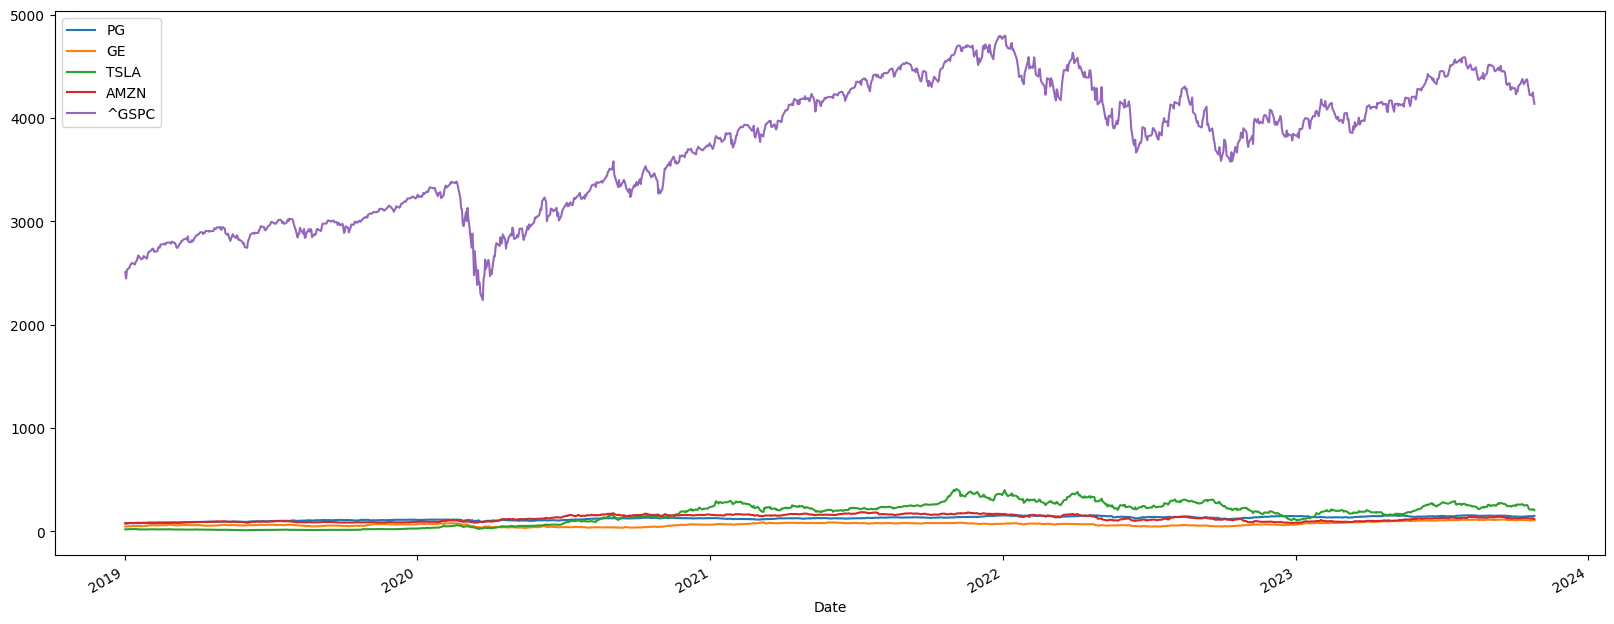

In [9]:
datos.plot(figsize = (20, 8))
plt.show

<Axes: xlabel='Date'>

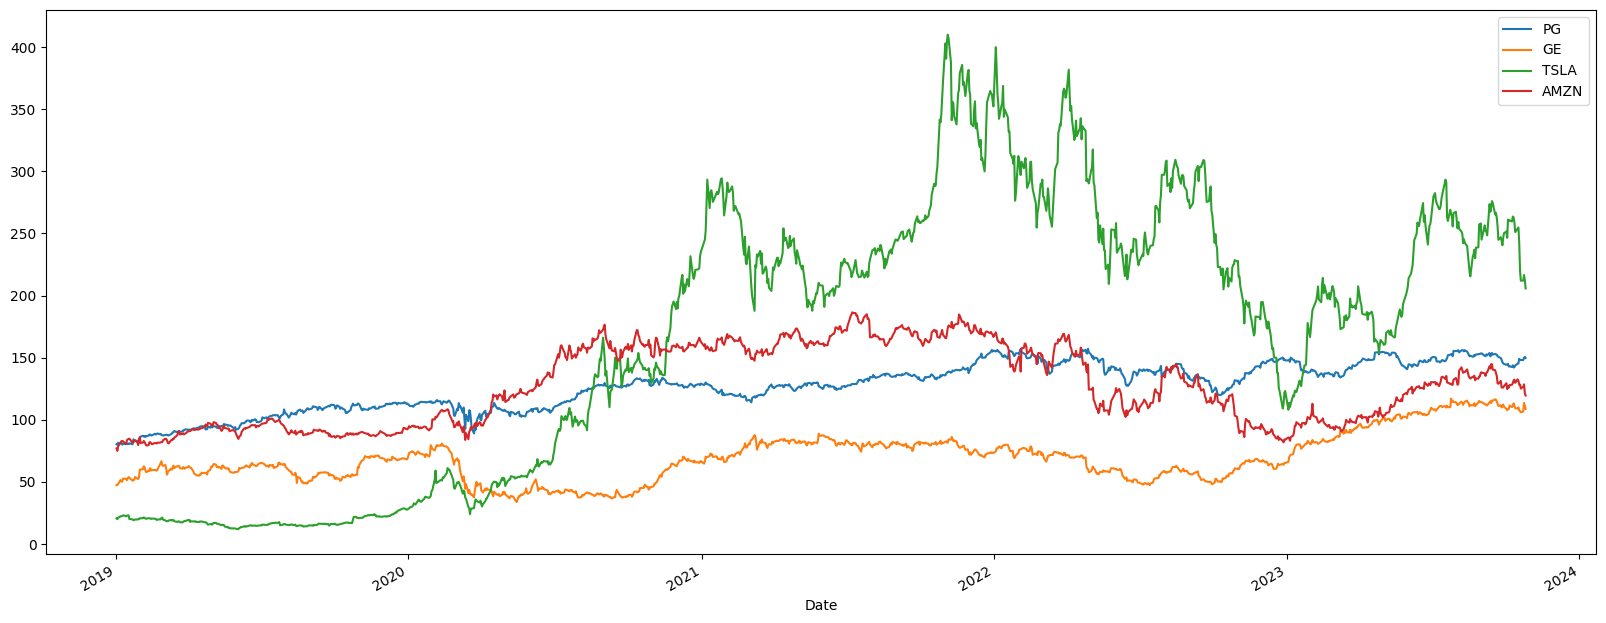

In [10]:
datos.drop('^GSPC', axis = 1).plot(figsize = (20, 8))

In [11]:
datos = datos.drop('^GSPC', axis = 1)
datos

,PG,GE,TSLA,AMZN
Date,,,,
2019-01-02,80.428246,47.434509,20.674667,76.956497
2019-01-03,79.864311,47.493423,20.024000,75.014000
2019-01-04,81.494385,48.495148,21.179333,78.769501
2019-01-07,81.168381,51.500324,22.330667,81.475502
2019-01-08,81.467934,50.439674,22.356667,82.829002
...,...,...,...,...
2023-10-20,148.050003,106.080002,211.990005,125.169998
2023-10-23,148.149994,106.690002,212.080002,126.559998
2023-10-24,149.899994,113.620003,216.520004,128.559998


# Retorno simple

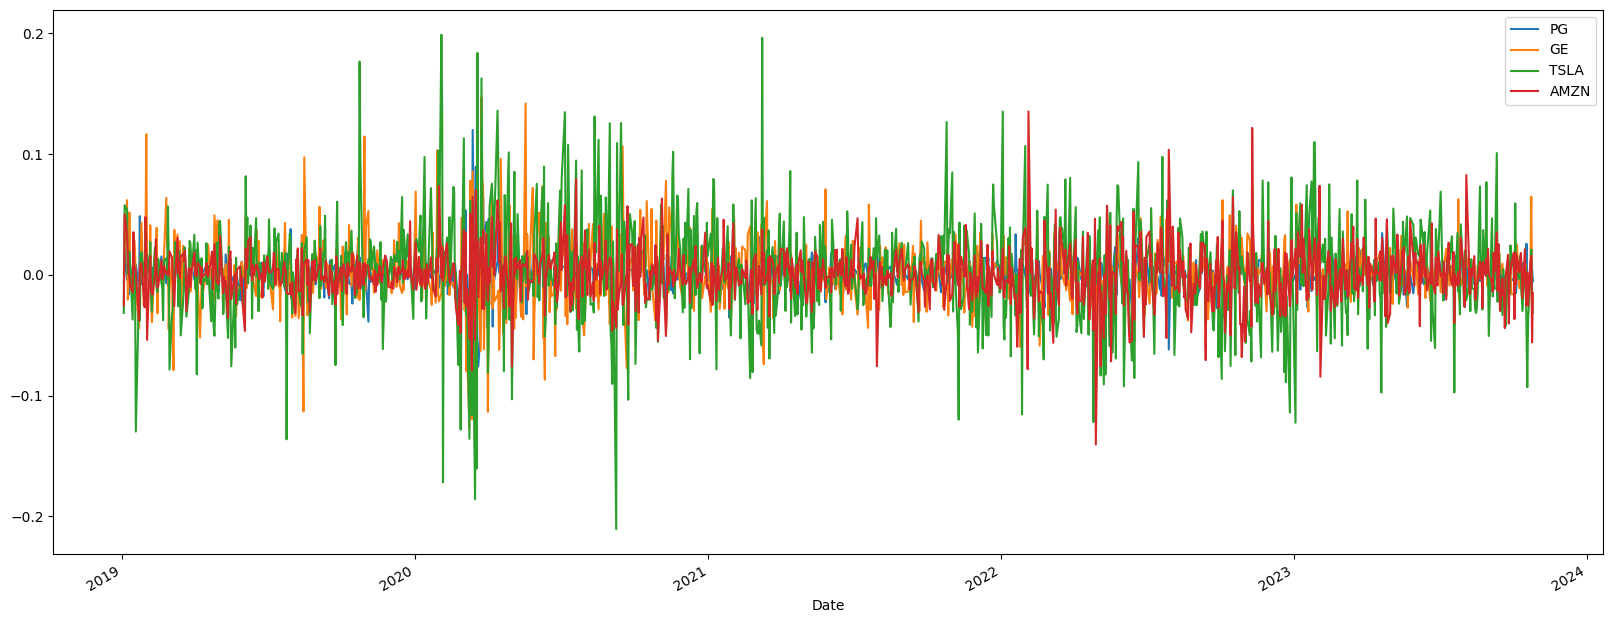

In [12]:
retorno_simple = datos.pct_change().dropna()
retorno_simple.plot(figsize = (20, 8))
plt.show()

# Retorno logarítmico

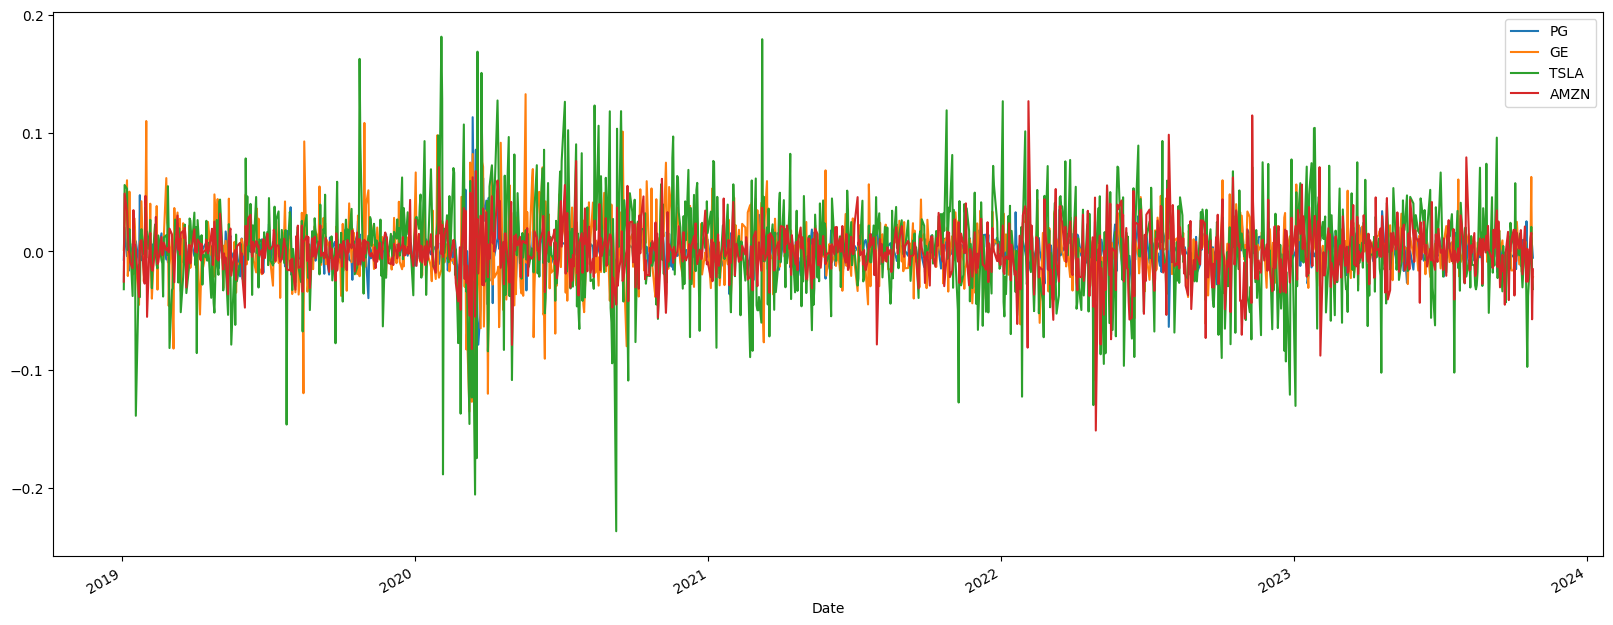

In [13]:
retorno_logaritmico = np.log(datos/datos.shift(1))
retorno_logaritmico.plot(figsize = (20, 8))
plt.show()

# Implementación algoritmo evolutivo

In [14]:
#Función de adaptabilidad
def evaluar_portafolio(individuo, ret_simple, ret_log):
    pesos = np.array(individuo) / np.sum(individuo)
    retorno_portafolio = np.dot((ret_simple.mean() * 250), pesos)
    riesgo_portafolio = np.sqrt(np.dot(pesos.T, np.dot((ret_log.cov() * 250), pesos)))
    return retorno_portafolio, riesgo_portafolio,

In [15]:
#Declarar el contenedor de los operadores genéticos
toolbox = base.Toolbox()

In [16]:
#Crear la clase función de adaptabilidad y la clase individuo
creator.create('FitnessMulti', base.Fitness, weights = (1.0, -1.0,))
creator.create('Individual', list, fitness = creator.FitnessMulti)

In [18]:
#Construir los mecanismos para el individuo y la poblacion
toolbox.register("attribute", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n = 4) #n es la cantidad de activos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [19]:
#Comprobar individuo, poblacion y adaptabilidad
ind = toolbox.individual()
print(ind)
ind.fitness.values = evaluar_portafolio(ind, retorno_simple, retorno_logaritmico)
print(ind.fitness.values)

[0.8064220023033045, 0.23490839485551007, 0.15731057158516393, 0.1735493687505858]
(0.23069720858362197, 0.21456290597153857)


In [20]:
ind / np.sum(ind)

array([0.58768961, 0.17119228, 0.11464195, 0.12647616])

In [25]:
#Crear los operadores geneticos
toolbox.register("evaluate", evaluar_portafolio, ret_simple = retorno_simple, ret_log = retorno_logaritmico)
toolbox.register("select", tools.selTournament, tournsize = 3)
toolbox.register("mate", tools.cxUniform, indpb = 0.5)
toolbox.register("mutate", tools.mutGaussian, mu = 0.1, sigma = 0.001, indpb = 0.1)

In [26]:
#Construir el algoritmo evolutuvo
tam_poblacion = 500
cantidad_generaciones = 50

In [27]:
#Estadisticos de operacion del algoritmo
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("promedio", np.mean)
stats.register("desviacion", np.std)
stats.register("minimo", np.min)
stats.register("maximo", np.max)

In [28]:
population = toolbox.population(n = tam_poblacion)
population, logbook = algorithms.eaSimple(population, toolbox, cxpb = 0.5, mutpb = 0.1,
                                          ngen = cantidad_generaciones, stats = stats,
                                         verbose = False)

In [29]:
print("El resultado de la evolucion es: ")
estadisticas = pd.DataFrame(logbook)
estadisticas

El resultado de la evolucion es: 


,gen,nevals,promedio,desviacion,minimo,maximo
0,0,500,0.303910,0.062005,0.160511,0.582239
1,1,244,0.350096,0.060967,0.210022,0.582239
2,2,278,0.402130,0.063791,0.258336,0.618140
3,3,262,0.453658,0.060714,0.299470,0.618140
4,4,276,0.499984,0.050595,0.356859,0.649262
5,5,272,0.538935,0.043902,0.390850,0.668193
6,6,252,0.568631,0.039179,0.352671,0.668193
7,7,267,0.591530,0.034402,0.494196,0.670709
8,8,282,0.612516,0.032087,0.489721,0.672332
9,9,247,0.631552,0.025270,0.543312,0.672332


In [32]:
mejor_individuo = tools.selBest(population,1)[0]
mejor_individuo

[0.003976186293938921,
 0.021269931462631342,
 2.099114285034037,
 0.002811023795367129]

Text(0, 0.5, 'Adaptabilidad')

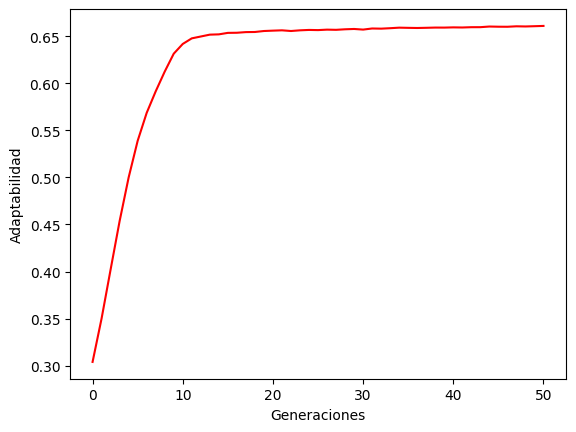

In [33]:
gen = logbook.select("gen")
avgs = logbook.select("promedio")
fig = plt.figure()
ax1 = plt.gca()
line1 = ax1.plot(gen, avgs, "r-", label = "Adaptabilidad promedio")
ax1.set_xlabel("Generaciones")
ax1.set_ylabel("Adaptabilidad")

In [34]:
mejor_individuo/np.sum(mejor_individuo)

array([0.00186924, 0.00999916, 0.98681012, 0.00132148])

In [35]:
evaluar_portafolio(mejor_individuo, retorno_simple, retorno_logaritmico)

(0.679977320443789, 0.6442828453002618)